In [15]:
import numpy
import pandas as pd
import csv
import matplotlib.pyplot as plt
import os

In [16]:
folder_bench='results-'
folder_cass='results-cassandra'
#default
experiment_date='2019-10-10T161034'
#large baggage
#experiment_date='2019-10-02T151015'
files = []

In [17]:
folder=folder_bench+experiment_date
with os.scandir(folder) as it:
    for file in it:
        if file.name.endswith('.csv') & file.is_file():
            files.append(folder+'/'+file.name)

In [18]:
data = pd.concat([pd.read_csv(f) for f in files])
traces = pd.read_csv(folder_cass+'/'+'traces-'+experiment_date+'.csv')

In [19]:
dft = pd.DataFrame(traces)
df = pd.DataFrame(data)
df['SpanDuration'] = df.FinishTime - df.StartTime
df.head(10)

,Service,TraceNumber,SpanNumber,StartTime,FinishTime,Sampled,SpanDuration
0,svc07,0,0,1570716634872787265,1570716634888930364,True,16143099
1,svc07,0,-1,1570716634872738856,1570716634888935874,True,16197018
2,svc07,1,0,1570716634918979799,1570716634933455947,True,14476148
3,svc07,1,-1,1570716634918967239,1570716634933459867,True,14492628
4,svc07,2,0,1570716634974071884,1570716634994797042,True,20725158
5,svc07,2,-1,1570716634974029794,1570716634994799212,True,20769418
6,svc07,3,0,1570716635033785157,1570716635053014852,True,19229695
7,svc07,3,-1,1570716635033773287,1570716635053017912,True,19244625
8,svc07,4,0,1570716635109242885,1570716635124103618,True,14860733
9,svc07,4,-1,1570716635109231285,1570716635124107588,True,14876303


In [6]:
df_transformed = df.copy()
df_transformed.StartTime = df.StartTime / 1000.0
df_transformed.FinishTime = df.FinishTime / 1000.0
df_transformed.SpanDuration = df.SpanDuration / 1000.0
df_transformed = df_transformed.astype({'StartTime': 'int64', 'FinishTime': 'int64', 'SpanDuration': 'int64'})
#Filter non-sampled span data
df_transformed = df_transformed.loc[df_transformed['Sampled']]
df_transformed = df_transformed.sort_values(by = 'StartTime')
df_transformed.reset_index(drop=True, inplace=True)
dft_sorted = dft.sort_values(by = 'start_time')
dft_sorted.reset_index(drop=True, inplace=True)

In [7]:
if len(dft_sorted) != len(df_transformed):
    print("Length of datasets is different!!")

In [8]:
df = dft_sorted.join(df_transformed)
df.head(10)

,trace_id,span_id,span_hash,duration,flags,logs,operation_name,parent_id,process,refs,start_time,tags,write_time,Service,TraceNumber,SpanNumber,StartTime,FinishTime,Sampled,SpanDuration
0,0x00000000000000004f2ae4ce007feebe,5704623451440934590,7569755470842888450,11511,1,"[{ts: 1570712635035719, fields: [{key: 'event'...",svc01-parent,0,"{service_name: 'svc01', tags: [{key: 'jaeger.v...",NaN,1570712635035677,"[{key: 'sampler.type', value_type: 'string', v...",1570712635993291,svc01,0,-1,1570712635035675,1570712635047190,True,11514
1,0x00000000000000004f2ae4ce007feebe,2924693825367182731,-7468535137719996778,11451,1,NaN,svc01-call-0,0,"{service_name: 'svc01', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",1570712635035728,"[{key: 'internal.span.format', value_type: 'st...",1570712635993934,svc01,0,0,1570712635035726,1570712635047184,True,11457
2,0x00000000000000004f2ae4ce007feebe,6983066297226362924,-5486192792199434793,5676,1,NaN,svc02-parent,0,"{service_name: 'svc02', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",1570712635041200,"[{key: 'Vagb2qsdXsiiAF7tuWjW', value_type: 'st...",1570712635993567,svc02,0,-1,1570712635041198,1570712635046898,True,5700
3,0x00000000000000004f2ae4ce007feebe,5200343846235948659,-6421715013230996934,5646,1,NaN,svc02-call-0,0,"{service_name: 'svc02', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",1570712635041224,"[{key: 'internal.span.format', value_type: 'st...",1570712635993583,svc02,0,0,1570712635041224,1570712635046873,True,5649
4,0x00000000000000000daadbd8cd78ae3d,984841192740531773,-1094938415321785335,14534,1,"[{ts: 1570712635085688, fields: [{key: 'event'...",svc01-parent,0,"{service_name: 'svc01', tags: [{key: 'jaeger.v...",NaN,1570712635085656,"[{key: 'sampler.type', value_type: 'string', v...",1570712635994334,svc01,1,-1,1570712635085654,1570712635100192,True,14537
5,0x00000000000000000daadbd8cd78ae3d,2377878632944436742,8416401846170879914,14487,1,NaN,svc01-call-0,0,"{service_name: 'svc01', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",1570712635085697,"[{key: 'internal.span.format', value_type: 'st...",1570712635993955,svc01,1,0,1570712635085696,1570712635100186,True,14490
6,0x00000000000000000daadbd8cd78ae3d,8695272201550386327,-9118081001943096822,5885,1,NaN,svc02-parent,0,"{service_name: 'svc02', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",1570712635094020,"[{key: 'Vagb2qsdXsiiAF7tuWjW', value_type: 'st...",1570712635993613,svc02,1,-1,1570712635094016,1570712635099906,True,5890
7,0x00000000000000000daadbd8cd78ae3d,8281374355292437000,7344120232598456110,5817,1,NaN,svc02-call-0,0,"{service_name: 'svc02', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",1570712635094077,"[{key: 'internal.span.format', value_type: 'st...",1570712635993546,svc02,1,0,1570712635094076,1570712635099902,True,5825
8,0x0000000000000000292cf0ea90648538,2967011144765834552,5592675701710716354,11354,1,"[{ts: 1570712635136140, fields: [{key: 'event'...",svc01-parent,0,"{service_name: 'svc01', tags: [{key: 'jaeger.v...",NaN,1570712635136120,"[{key: 'sampler.type', value_type: 'string', v...",1570712635993213,svc01,2,-1,1570712635136116,1570712635147476,True,11360
9,0x0000000000000000292cf0ea90648538,4987854414061646171,-2806274532525145434,11300,1,NaN,svc01-call-0,0,"{service_name: 'svc01', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",1570712635136154,"[{key: 'internal.span.format', value_type: 'st...",1570712635994216,svc01,2,0,1570712635136152,1570712635147466,True,11313


## Assumptions for Calculations
Assumptions necessary for calculation of trace completion times, i.e. the point in time a all Spans of a trace have been written to a database.
1. All Traces are completed, i.e. all Spans part of a Trace are in the dataset
1. All Spans are sorted by their StartTime in ascending order
    * Monotonic increasing timestamps can only be assumed safely while there are no "parallel" paths in a trace
    * Also, work time distributions other than static ones will inevitably disperse spans across the dataset
1. There is one operation/service, that is consistently the 'last' one to be invoked and also the last one in the dataset
    * This operation serves as a marker for the last Span in a trace
    * Probably the first assumption that has to be revoked -> we need to to "count" spans part of a trace as an alternative to static iteration

In [9]:
df['span_visibility'] = df.write_time - df.StartTime
starttime = 0
completion_times = []
write_times_tmp = []
for index, row in df.iterrows():
    #save the write time of current span in temp list
    write_times_tmp.append(row['write_time'])
    if row['operation_name'] == 'svc01-parent':
        #if the operation name is the root operation, we can assume this is the first time a trace has been seen,
        #so use this start time for the trace
        starttime = row['StartTime']
    if row['operation_name'] == 'svc10-parent':
        #this is the "last" span in the deployment, so we can safely assume for this trace no more spans(=rows)
        #follow because they are sorted by time in monotonically increasing order
        #take the maximum (i.e. latest) of write times and subtract the starttime to get trace completion time
        #TODO: can we use a generic approach to identify the "last" span in the list of all created spans?
        #TODO: it would make more sense to have the trace completion time at the root span (or at all spans?)
        completion_times.append(max(write_times_tmp) - starttime)
        write_times_tmp = []
    else:
        #for all rows that are not the last span of a trace, add a zero,
        #so we can easily add the list to the pandas dataframe
        completion_times.append(0)

In [10]:
zeroCount = 0
completion_times_f = completion_times.copy()
for i in range(0,len(completion_times)):
    if completion_times[i] == 0:
        zeroCount = zeroCount + 1
    else:
        for j in range(i-zeroCount, i):
            completion_times_f[j] = completion_times[i]
        zeroCount = 0
#completion_times_f
df['completion_time'] = completion_times_f

In [11]:
df.head(6)

,trace_id,span_id,span_hash,duration,flags,logs,operation_name,parent_id,process,refs,...,write_time,Service,TraceNumber,SpanNumber,StartTime,FinishTime,Sampled,SpanDuration,span_visibility,completion_time
0,0x00000000000000004f2ae4ce007feebe,5704623451440934590,7569755470842888450,11511,1,"[{ts: 1570712635035719, fields: [{key: 'event'...",svc01-parent,0,"{service_name: 'svc01', tags: [{key: 'jaeger.v...",NaN,...,1570712635993291,svc01,0,-1,1570712635035675,1570712635047190,True,11514,957616,1135814
1,0x00000000000000004f2ae4ce007feebe,2924693825367182731,-7468535137719996778,11451,1,NaN,svc01-call-0,0,"{service_name: 'svc01', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",...,1570712635993934,svc01,0,0,1570712635035726,1570712635047184,True,11457,958208,1135814
2,0x00000000000000004f2ae4ce007feebe,6983066297226362924,-5486192792199434793,5676,1,NaN,svc02-parent,0,"{service_name: 'svc02', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",...,1570712635993567,svc02,0,-1,1570712635041198,1570712635046898,True,5700,952369,1135814
3,0x00000000000000004f2ae4ce007feebe,5200343846235948659,-6421715013230996934,5646,1,NaN,svc02-call-0,0,"{service_name: 'svc02', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",...,1570712635993583,svc02,0,0,1570712635041224,1570712635046873,True,5649,952359,1135814
4,0x00000000000000000daadbd8cd78ae3d,984841192740531773,-1094938415321785335,14534,1,"[{ts: 1570712635085688, fields: [{key: 'event'...",svc01-parent,0,"{service_name: 'svc01', tags: [{key: 'jaeger.v...",NaN,...,1570712635994334,svc01,1,-1,1570712635085654,1570712635100192,True,14537,908680,1135814
5,0x00000000000000000daadbd8cd78ae3d,2377878632944436742,8416401846170879914,14487,1,NaN,svc01-call-0,0,"{service_name: 'svc01', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",...,1570712635993955,svc01,1,0,1570712635085696,1570712635100186,True,14490,908259,1135814


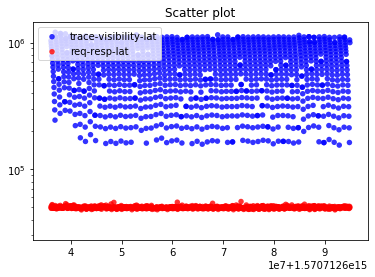

In [12]:
df.drop(df.index[:100], inplace=True)
df_roots = df.loc[df['operation_name'] == 'svc01-parent']
colors = {'red', 'blue'}
categories = {'req-resp-lat', 'trace-visibility-lat'}
columns = {'duration', 'completion_time'}
scatterplot = plt.figure()
ax = scatterplot.add_subplot(1, 1, 1)
for column, color, cat in zip(columns, colors, categories):
    x, y = df_roots['StartTime'], df_roots[column]
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=cat)
plt.title('Scatter plot')
plt.yscale("log")
plt.legend(loc=2)
plt.show()

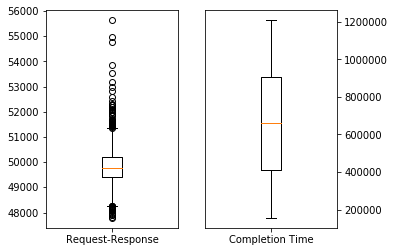

In [13]:
#plt.title('Visibility Delay')
figure1, axes = plt.subplots(1, 2)
#apparently we have too much stuff going on at the righthand y-axis, so we need to add extra space
figure1.subplots_adjust(right=0.8)
#axes[0].text('Latency [µs]')
label = 'exp'
#label = 'large-baggage'
axes[0].boxplot([df_roots['duration']], labels=['Request-Response'])
#plt.savefig('latency-high-baggage.pdf')
axes[1].boxplot([df_roots['completion_time']], labels=['Completion Time'])
axes[1].yaxis.tick_right()
figure1.savefig('latency-'+label+'.pdf')
#plt.savefig('completion-high-baggage.pdf')
#plt.savefig('completion'+label+'.pdf')
#plot = plt.boxplot([df_roots['duration'], df_roots['completion_time']], labels=['Request-Response','Trace Completion'])

In [14]:
df_roots = df_roots[['duration', 'SpanDuration', 'span_visibility', 'completion_time']]
numpy.round(df_roots.describe().T, 2).to_csv('summary-'+label+'.csv', sep=',')